**Antes que nada correr esta celda para poder usar julia**

In [ ]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

In [2]:
import Pkg

In [3]:
Pkg.add("Plots")

In [4]:
using Plots

#### Circulo

In [5]:
struct Círculo
end

In [6]:
function circleShape(h,k,r)
  θ = LinRange(0, 2*π, 500)
  h .+ r*sin.(θ), k .+ r*cos.(θ)
end

circleShape (generic function with 1 method)

In [7]:
function plotear_circulo()
  #circleShape(h,k,r) donde h,k es el centro del circulo y r es el radio

  plot(circleShape(0,0,1), seriestype = [:shape,], lw = 0.5, c =:blue, linecolor = :black, legends = false, fillalpha = 0.2, aspect_ratio = 1)
end

plotear_circulo (generic function with 1 method)

#### Ondas

┌ Info: Saved animation to 
│   fn = /content/sen_cos_tdl.gif
└ @ Plots /root/.julia/packages/Plots/ldLtW/src/animation.jl:104


Plots.AnimatedGif("/content/sen_cos_tdl.gif")
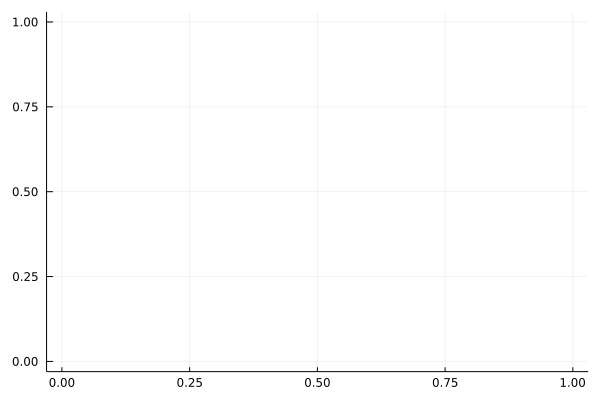

In [8]:
gr() 
p = plot([sin, cos], zeros(0), leg = false)
anim = Animation()
for x = range(0, stop = 10π, length = 100)
  push!(p, x, Float64[sin(x), cos(x)])
  frame(anim)
end
gif(anim, "sen_cos_tdl.gif", fps = 15)

#### Circulo animado

In [9]:
@userplot CirclePlot
    @recipe function f(cp::CirclePlot)
      x, y, i = cp.args
      n = length(x)
      inds = circshift(1:n, 1 - i)
      linewidth --> range(0, 10, length = n)
      seriesalpha --> range(0, 1, length = n)
      aspect_ratio --> 1
      label --> false
      x[inds], y[inds]
  end

In [10]:
function plotear_circulo_animado()
  n = 150
  t = range(0, 2π, length = n)
  x = sin.(t)
  y = cos.(t)

  anim2 = @animate for i ∈ 1:n
    circleplot(x, y, i)
  end
  gif(anim2, "anim2_fps15.gif", fps = 30)
end

plotear_circulo_animado (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /content/anim2_fps15.gif
└ @ Plots /root/.julia/packages/Plots/ldLtW/src/animation.jl:104


Plots.AnimatedGif("/content/anim2_fps15.gif")
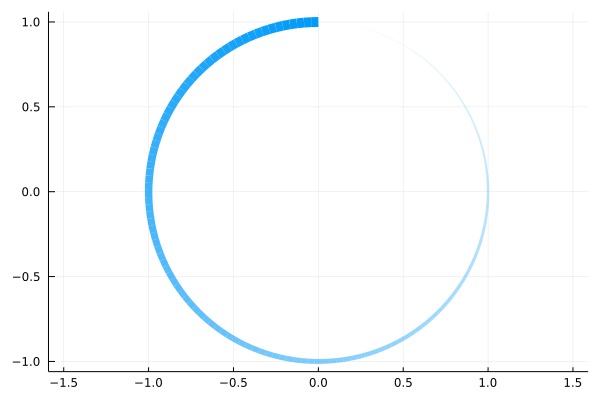

In [11]:
plotear_circulo_animado()

In [12]:
function plotear_circulo_animado_colorido()
  @gif for i ∈ 1:n
    circleplot(x, y, i, line_z = 1:n, cbar = false, framestyle = :zerolines)
  end every 5
end

plotear_circulo_animado_colorido (generic function with 1 method)

#### Plotear corazon

In [13]:
struct Corazon
end

In [14]:
function plotear_corazon()
  nn = 100
  tt = range(0, 2π, length = nn)
  xx = 16sin.(tt).^3
  yy = 13cos.(tt) .- 5cos.(2tt) .- 2cos.(3tt) .- cos.(4tt)
  @gif for i ∈ 1:nn
    circleplot(xx, yy, i, line_z = 1:nn, cbar = false, c = :reds, framestyle = :none)
  end when i > 40 && mod1(i, 10) == 5
end

plotear_corazon (generic function with 1 method)

#### Plotear esfera

In [15]:
struct Esfera

end

In [16]:
function plotear_esfera()
  ϕs = range(-π, π, length = 50)
  θs = range(0, π, length = 25)
  θqs = range(1, π - 1, length = 25)
  x_3 = vec([sin(θ) * cos(ϕ) for (ϕ, θ) = Iterators.product(ϕs, θs)])
  y_3 = vec([sin(θ) * sin(ϕ) for (ϕ, θ) = Iterators.product(ϕs, θs)])
  z_3 = vec([cos(θ) for (ϕ, θ) = Iterators.product(ϕs, θs)])
  u_3 = 0.1 * vec([sin(θ) * cos(ϕ) for (ϕ, θ) = Iterators.product(ϕs, θqs)])
  v_3 = 0.1 * vec([sin(θ) * sin(ϕ) for (ϕ, θ) = Iterators.product(ϕs, θqs)])
  w_3 = 0.1 * vec([cos(θ) for (ϕ, θ) = Iterators.product(ϕs, θqs)])
  quiver(x_3, y_3, z_3, quiver = (u_3, v_3, w_3))
end

plotear_esfera (generic function with 1 method)

####Plotear lorenz

In [17]:
Base.@kwdef mutable struct Lorenz
    dt::Float64 = 0.02
    σ::Float64 = 10
    ρ::Float64 = 28
    β::Float64 = 8/3
    x::Float64 = 1
    y::Float64 = 1
    z::Float64 = 1
end
 
function plotear_lorenz()

  function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x)
    dy = l.x * (l.ρ - l.z) - l.y
    dz = l.x * l.y - l.β * l.z
    l.x += l.dt * dx
    l.y += l.dt * dy
    l.z += l.dt * dz
  end
  
  attractor = Lorenz()

  # initialize a 3D plot with 1 empty series
  plt_lorenz = plot3d(1,xlim = (-30, 30),ylim = (-30, 30),zlim = (0, 60),title = "Lorenz Attractor",marker = 2,)

  # build an animated gif by pushing new points to the plot, saving every 10th frame
  @gif for i=1:1500
    step!(attractor)
    push!(plt_lorenz, attractor.x, attractor.y, attractor.z)
  end every 10
end

plotear_lorenz (generic function with 1 method)

#Multiple Dispatch

Es un concepto muy importante en Julia. Ahora ¿Que pingo significa esto ura?. Ya te explico chango, la cosa es así.

Nosotros cuando hablamos de un envio simple estamos hablando de un proceso en donde elegimos un método diferente o versión de una función dependiendo del tipo de entrada

Y el envio multiple (*Multiple dispatch*) significa que miramos todos los tipos de entrada para todos los argumentos de la función para elegir que método o versión vamos a llamar

In [ ]:
#Defino un numero complejo
cc = 3 +4im #Para definir un imaginario se pone im dsp del num

3 + 4im

In [ ]:
#Para poder ver que es lo que realmente hace Julia voy a usar un macro
@which cc + cc

+(z::Complex, w::Complex) in Base at complex.jl:275

Lo que me dice lo de arriba es que se usa un método que recibe dos numeros complejos y los suma.

Ahora vamos a ver que pasa si sumamos un numero real

In [ ]:
@which cc + 4 

+(z::Complex, x::Real) in Base at complex.jl:313

Vemos que ahora llama a otro método, entonces esto quiere decir que entre todas las funciones definidas para la suma llama especificamente a aquellas que reciba ciertos parametros esperados

In [ ]:
#Vuelvo a probar pero invirtiendo
@which 4 + cc

+(x::Real, z::Complex) in Base at complex.jl:312

In [ ]:
#Quiero ver cuantos métodos de "+" hay
+

+ (generic function with 190 methods)

**Nota importante**, cada vez que usamos este macro nos da un link a la implementación, tenganlo en cuenta

---

#### Plots

In [18]:
begin
  plotear(lorenz::Lorenz) = return plotear_lorenz()
  plotear(esfera::Esfera) = return plotear_esfera()
  plotear(corazon::Corazon) = return plotear_corazon()
  plotear(circulo::Círculo) = return plotear_circulo()
  plotear(x) = return("No hay nada para plotear")
end

plotear (generic function with 5 methods)

In [21]:
x = 1

1

In [22]:
plotear(1)

"No hay nada para plotear"

##### Circulo 

In [23]:
circulo = Círculo()

Círculo()

In [ ]:
plotear(circulo)

##### Esfera

In [25]:
esfera = Esfera()

Esfera()

In [ ]:
plotear(esfera)

##### Corazón

In [27]:
coraxao = Corazon()

Corazon()

In [ ]:
plotear(coraxao)

##### Lorenz

In [29]:
lorenzo = Lorenz()

Lorenz(0.02, 10.0, 28.0, 2.6666666666666665, 1.0, 1.0, 1.0)

In [ ]:
plotear(lorenzo)

# Multi Threading

Este modelo de paralelismo tiene muchas propiedades maravillosas. Lo vemos como algo análogo a la recolección de basura: con GC, usted asigna objetos libremente sin preocuparse por cuándo y cómo se liberan. Con el paralelismo de tareas, genera tareas libremente (potencialmente millones de ellas) sin preocuparse por dónde se ejecutan.

In [ ]:
import Distributed
using Distributed

In [ ]:
nprocs() # Para ver la cantidad de procesos

1

In [ ]:
workers() # Para ver la cantidad de workers

1-element Vector{Int64}:
 1

In [ ]:
addprocs(1) # Para agregar más procesos

1-element Vector{Int64}:
 2

In [ ]:
nprocs() # Para ver la cantidad de procesos

2

In [ ]:
workers() 

1-element Vector{Int64}:
 2

In [ ]:
rmprocs(2) # Para sacar procesos

Task (done) @0x00007f4c38d08a90

In [ ]:
nprocs() 

1

In [ ]:
workers()

1-element Vector{Int64}:
 1

---

In [ ]:
function F(n)
    if n < 2
        return n
    else
        return F(n-1)+F(n-2)
    end
end

F (generic function with 1 method)

In [ ]:
F(30)

832040

In [ ]:
@time F(30);

  0.005672 seconds


In [ ]:
import Base.Threads.@spawn

In [ ]:
function fib(n::Int)
    if n < 2
        return n
    end
    t = @spawn fib(n - 2)
    return fib(n - 1) + fetch(t)
end

fib (generic function with 1 method)

In [ ]:
fib(3)

2

In [ ]:
@macroexpand @spawn fib(n - 2)

quote
    #= threadingconstructs.jl:172 =#
    let
        #= threadingconstructs.jl:173 =#
        local var"#61#task" = Base.Threads.Task((()->begin
                            #= threadingconstructs.jl:169 =#
                            fib(n - 2)
                        end))
        #= threadingconstructs.jl:174 =#
        (var"#61#task").sticky = false
        #= threadingconstructs.jl:175 =#
        if $(Expr(:islocal, Symbol("##sync#41")))
            #= threadingconstructs.jl:176 =#
            Base.Threads.put!(var"##sync#41", var"#61#task")
        end
        #= threadingconstructs.jl:178 =#
        Base.Threads.schedule(var"#61#task")
        #= threadingconstructs.jl:179 =#
        var"#61#task"
    end
end

## Datos mientras estudio concurrencia (borrar para la entrega final)


Task es una corutina es un hilo ligero que se comunica entre múltiples tareas a través del canal.

Es un tipo de dato que nos permite usar una unidad de trabajo computacional que podamos ejecutar cuando queramos y que se ejecute en su propia tarea (Se corre asinconicamente)

El canal puede verse como una tubería, legible en un extremo y grabable en un extremo.

- Se pueden pasar diferentes tareas **put!** Escribir simultáneamente en el mismo canal
- También se pueden pasar diferentes tareas **take!** Obtener datos simultáneamente del mismo canal

**Definición del canal**

Channel(func::Function, ctype=Any, csize=0, taskref=nothing)

Crea un **Channel** con un búfer interno que puede contener un máximo de *size* objetos de tipo *T*. 

**put!** invoca un bloque de canal completo hasta que se elimina un elemento con **take!**.

In [ ]:
c1 = Channel(32)
c2 = Channel{Float64}(32)
put!(c1, 1)
put!(c2, 2)

2.0

In [ ]:
c1

Channel{Any}(32) (1 item available)

In [ ]:
c2

Channel{Float64}(32) (1 item available)

In [ ]:
take!(c2)

2.0

In [ ]:
c2

Channel{Float64}(32) (empty)

**Despues de cerrar el canal no se puede escribir más**

In [ ]:
close(c1)
#put!(c1, 3) # debería romepr

In [ ]:
c1

Channel{Any}(32) (closed)

Pero se puede leer, **fetch** Solo puede leer los primeros datos, pero no eliminará los datos del canal, perotake!Se eliminará después de leer.

- Si un canal está vacío, la tarea de lectura (es decir, la tarea que toma tomar) se bloqueará hasta que los nuevos datos estén listos.

- Si un canal está lleno, la tarea escrita (es decir, la tarea que ejecuta put) se bloqueará hasta que el canal esté libre.

- isready se puede usar para verificar si un canal tiene elementos ya preparados y esperar a que un elemento esté listo, use wait.

- Inicialmente, se activa un canal, lo que significa que se puede leer con take! Y escribir con put !. close cerrará un canal, para un canal cerrado, **put!** Fallará

El canal puede atravesarse en un bucle for. En este momento, el bucle continuará ejecutándose hasta que haya datos en el canal. Durante el recorrido, se recuperarán todos los valores agregados al canal. Una vez que el canal está cerrado o vacío, el ciclo for terminará.

http://ferestrepoca.github.io/paradigmas-de-programacion/paralela/tutoriales/julia/notebooks/parallelProgrammingApplicationsSlides.html#/ 

---

In [4]:
Threads.nthreads()

1

In [7]:
Pkg.add(Threads)

LoadError: ignored

In [5]:
export JULIA_NUM_THREADS = 4

LoadError: ignored